In [5]:
import torch as tr
import numpy as np
from CSW import *

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# task
pr = 1.0
taskL = [CSWTask(pr),CSWTask(1-pr)]

eval_pathL = [
  [10,0,1,4,5],       
  [11,0,1,3,5],
  ]

xeval = taskL[0].format_Xeval(eval_pathL)
xeval = tr.tensor(xeval)

In [7]:
## params
seed = 0
stsize = 40
learn_rate = 0.005
neps = 200
block_len = 1
## train setup
softmax = lambda ulog: tr.softmax(ulog,-1)
lossop = tr.nn.CrossEntropyLoss()


## loop over seeds
lossL = []
# init net
net = CSWNet(stsize,seed)
optiop = tr.optim.Adam(net.parameters(), lr=learn_rate)
# eval array: y_softmax
tdim,sm_dim=5,12
ysm = -np.ones([2,neps,tdim,sm_dim])
## train loop
task_int = 0
for ep in range(neps):
  if ep == 160:
    block_len = 1
  # select graph
  if ep%block_len==0:
    task_int = (task_int+1)%2
    task = taskL[task_int]
    filler_id = 10+task_int 
  # forward prop  
  path = task.sample_path()
  xtrain,ytrain = task.dataset_onestory_with_marker(path=path,filler_id=filler_id,depth=1)
  yh = net(xtrain) # (time,smunits)
  # eval
  for idx,xev in enumerate(xeval):
    ysm_t = softmax(net(xev)).detach().numpy()
    ysm[idx,ep] = ysm_t
  # backprop
  loss = 0
  for tstep in range(len(xtrain)):
    loss = lossop(yh[tstep].unsqueeze(0),ytrain[tstep])
    optiop.zero_grad()
    loss.backward(retain_graph=True)
    optiop.step()
  lossL.append(loss)



(2, 200, 5, 12)


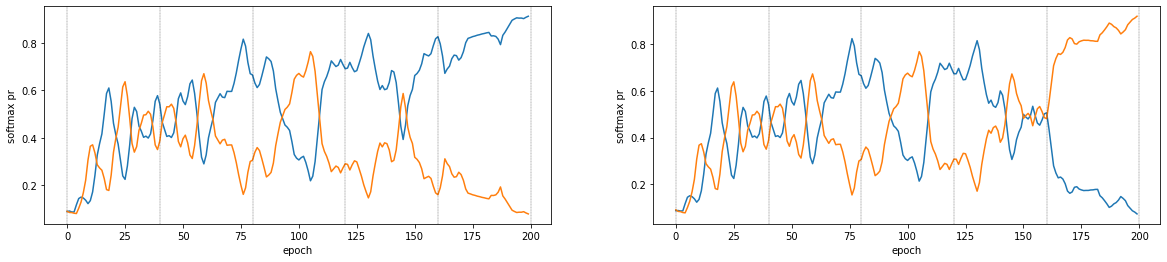

In [23]:
print(ysm.shape)# (graph,epoch,time_step,output_unit)

fig,axarr = plt.subplots(1,2,figsize=(20,4))
for graph_idx in range(2):
  ax = axarr[graph_idx]
  ax.plot(ysm[graph_idx,:,2,(3,4)].T)
  ax.set_ylabel('softmax pr')
  ax.set_xlabel('epoch')
  
  for block_t in range(0,201,40):
    ax.axvline(block_t,c='k',ls='--',lw=.3)